<a href="https://colab.research.google.com/github/k73kahori/kaggle-notebook/blob/main/Histopathologic_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Histopathologic Cancer Detection**  
### **Identify metastatic tissue in histopathologic scans of lymph node sections**  
引用：https://www.kaggle.com/competitions/histopathologic-cancer-detection

## Table of Contents  
- 概要  
- データのダウンロード  
- ライブラリのインポート
- ラベルデータの確認
- 画像データの確認
- ベースライン
- モデルのブラッシュアップ
- テストデータでの汎化性能確認
- まとめ

## 【概要】
1. 目的  
リンパ節のデジタル病理画像の一部の領域（中央32×32pxのパッチ）に転移性腫瘍があるかどうかを予測するモデルを構築する。  

2. データセット  
trainフォルダ内に学習用のデジタル病理画像（tif形式、96×96px、HE染色(3channel)）が保存されている。  
train_labels.csvファイルに、画像IDとその分類（label; positive(1) or negative(0))の参照が記述されている（画像データのファイル名はID.tifとなる）。

## 【データのダウンロード】

In [ ]:
# Mount hte Google drive to the Colab notebook
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
# /content直下に学習用の画像データフォルダを解凍
# ランタイムのリサイクル時には削除される

# unzip the zip files
!unzip "/content/drive/MyDrive/DataSets/Histopathologic Cancer Detection/train.zip"

ストリーミング出力は最後の 5000 行に切り捨てられました。
  inflating: fa2c657eff58b6802cb32843caa2fac25b67c2c9.tif  
  inflating: fa2c775c4457d0aeb7e57216849eef5f4e72e566.tif  
  inflating: fa2c77e1707c2fe7b0016e00736fb6e4b7f09488.tif  
  inflating: fa2ce5e802dd281bd98fcfb538e80b9c96c2b7af.tif  
  inflating: fa2d24e4a109d2d3a925890aaed4e0f038dfffb0.tif  
  inflating: fa2d7e4865aa7869d2dd85116323b8405c94f1c2.tif  
  inflating: fa2d8b2e4acf46e278e2e7acbc034c263d970737.tif  
  inflating: fa2df9148831509a181797db79eb1a7bf39593f1.tif  
  inflating: fa2e6db0b35484797f58005e3a6e24ca75fbca76.tif  
  inflating: fa2e80e84594465329bdc0c8d1b3a507275fbb4d.tif  
  inflating: fa2eaf8ec6267fa928a88775dc15ee25b633c537.tif  
  inflating: fa2ebf31ff5954570526d4835ac5368fabc1f035.tif  
  inflating: fa2efd2dda5235a3e397ea0dd637ea13a78f7599.tif  
  inflating: fa2f1d5e86165f63c57acdf9d23521f2b8070e0c.tif  
  inflating: fa2ffac7f7abed98942f6fabb0a5ef64ddd17f54.tif  
  inflating: fa3006af8c223d7e6d1920a17756d73a26603455.tif  
  inflat

In [ ]:
import os 
# ファイル数を確認したいディレクトリのパスを指定
path = '/content'
 
#ファイル数を出力
print(sum(os.path.isfile(os.path.join(path, name)) for name in os.listdir(path)))


220026


220,025個全ての画像データと_lavel.csvファイルをダウンロードできた

---

## 【ライブラリのインポート】

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import os
import glob

# 画像処理
from PIL import Image
import cv2

# Keras
from tensorflow import keras
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

# データの分割
from sklearn.model_selection import train_test_split

# sklearn
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# GridSearch
from sklearn.model_selection import GridSearchCV

# JupyterNotebook上でグラフを表示する設定
%matplotlib inline
# DataFrameで全ての列を表示する設定
pd.options.display.max_columns = None

---

## 【ラベルデータの確認】

In [ ]:
# データの確認
train_labels = pd.read_csv('/content/_labels.csv')
train_labels.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

学習用の画像データのファイル名は "{id}.tif" となっている  
idの並び方は順不同

In [ ]:
# 形状の確認
train_labels.shape

(220025, 2)

0    130908
1     89117
Name: label, dtype: int64


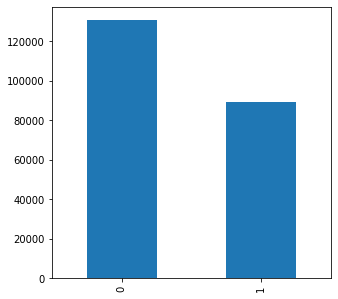

In [ ]:
# 目的変数となるクラスの分布を確認
balance = train_labels['label'].value_counts()
# 棒グラフで表示
print(balance)
balance.plot.bar(figsize=(5,5))

Negative(0: non-malignant): 130908 cases(60%)  
Positive(1: malignant) : 89117 cases(40%)

In [ ]:
# Nullの確認
train_labels.isnull().sum()

id       0
label    0
dtype: int64

In [ ]:
# 欠損値の確認
train_labels.isna().sum()

id       0
label    0
dtype: int64

In [ ]:
# idに重複があるかを確認
train_labels[train_labels.duplicated(keep=False)]

Empty DataFrame
Columns: [id, label]
Index: []

idに重複はない

---

## 【画像データの確認】

id  label
151577  00001b2b5609af42ab0ab276dd4cd41c3e7745b5      1

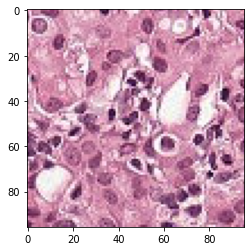

In [ ]:
# 学習用画像データを1枚取得し画像を確認
# 出力はndarray形式
sample_img1_ = cv2.imread("/content/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif")
# BGR→RGBに変換
sample_img1 = cv2.cvtColor(sample_img1_, cv2.COLOR_BGR2RGB)
plt.imshow(sample_img1)

# ラベル確認
train_labels.query("id == '00001b2b5609af42ab0ab276dd4cd41c3e7745b5'")

sample_img1はPositive（転移性腫瘍あり）

In [ ]:
# 要素の最大値を確認
np.amax(sample_img1.flatten())

255

id  label
143371  0a0a8bdf1d78af77dcc0b94aef6fb5c2f841a3c0      0

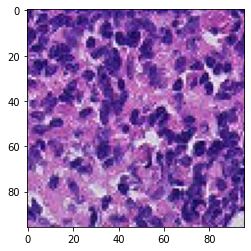

In [ ]:
# もう一枚画像確認
sample_img2_ = cv2.imread("/content/0a0a8bdf1d78af77dcc0b94aef6fb5c2f841a3c0.tif")
# BGR→RGBに変換
sample_img2 = cv2.cvtColor(sample_img2_, cv2.COLOR_BGR2RGB)
plt.imshow(sample_img2)

# ラベル確認
train_labels.query("id == '0a0a8bdf1d78af77dcc0b94aef6fb5c2f841a3c0'")

sample_img2はNegative（転移性腫瘍なし）

In [ ]:
# 要素の最大値を確認
np.amax(sample_img2.flatten())

255

In [ ]:
# 形状を確認
print(sample_img1.shape)
print(sample_img2.shape)

(96, 96, 3)
(96, 96, 3)


In [ ]:
# データ型を確認
print(sample_img1.dtype)
print(sample_img2.dtype)

uint8
uint8


画像データのサイズは96×96pxのRGB画像  
このうち、**中央の32×32px内に1pxでも転移性の腫瘍(metastasis)がある場合、Positiveに判定**される

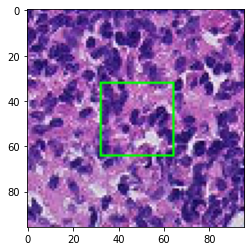

In [ ]:
# 画像の中の対象部分を正方形で囲む
sample_img2_rect = cv2.rectangle(sample_img2,  # 対称画像(ndarray形式)
                  pt1=(32,32),                    # 開始点の座標
                  pt2=(64,64),                    # 終点の座標
                  color=(0,255,0),                # カラー(B,G,R)
                  thickness=1,                    # 直線の太さ
                  )

plt.imshow(sample_img2_rect)

(32, 32, 3)


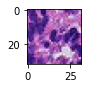

In [ ]:
# 判定に用いる部分のみ切り出し
# もう一度読み込み
sample_img2_ = cv2.imread("/content/0a0a8bdf1d78af77dcc0b94aef6fb5c2f841a3c0.tif")
# BGR→RGBに変換
sample_img2 = cv2.cvtColor(sample_img2_, cv2.COLOR_BGR2RGB)

# 対象部分を切り抜く
sample_img2_crop = sample_img2[32:64, 32:64, :]

# 切り抜いた画像の表示
plt.figure(figsize=(1, 1))
plt.imshow(sample_img2_crop)

print(sample_img2_crop.shape)

《データの容量（メモ）》  
- 256階調のRGB画像  
　→256×256×256 = 2**24  
　→1pxあたり24bit = 3バイト（RGBそれぞれ8bitずつ）  
- 画素数：96×96px
- データ数：220025枚

- 1データあたりの情報量：96×96×3 = 27648バイト = 27KB
- crop後の画像：32×32×3 = 3072バイト = 3KB

- 27KB × 220025枚 = 5940675KB = 5.7GB
- 3KB × 220025枚 = 0.63GB



#### １．Negative(non-metastatic)

In [ ]:
# Negativeに分類されるデータ
nega_df = train_labels.query("label == 0")
nega_df.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0
5  acfe80838488fae3c89bd21ade75be5c34e66be7      0

In [ ]:
# Negativeに分類されるデータのidを取得（出力はndarray)
nega_id = nega_df.loc[:, "id"].values
print("nega_id.shape =", nega_id.shape)
# 最初の5個のみ表示
nega_id[:5]

nega_id.shape = (130908,)


array(['f38a6374c348f90b587e046aac6079959adf3835',
       '755db6279dae599ebb4d39a9123cce439965282d',
       'bc3f0c64fb968ff4a8bd33af6971ecae77c75e08',
       '068aba587a4950175d04c680d38943fd488d6a9d',
       'acfe80838488fae3c89bd21ade75be5c34e66be7'], dtype=object)

In [ ]:
# 学習用の画像データが保存されているフォルダのパス
imgpath ="/content"

In [ ]:
# Negativeに分類される画像データにアクセスするパスを作成
# 最初の5個のみ表示
cnt = 0
for i in nega_id:
  filename = i + ".tif"
  # imgpath と filename を結合し、画像データにアクセスするパスを作る
  join_path = os.path.join(imgpath, filename)
  cnt += 1
  print(join_path)
  if cnt > 4:
    break

/content/f38a6374c348f90b587e046aac6079959adf3835.tif
/content/755db6279dae599ebb4d39a9123cce439965282d.tif
/content/bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
/content/068aba587a4950175d04c680d38943fd488d6a9d.tif
/content/acfe80838488fae3c89bd21ade75be5c34e66be7.tif


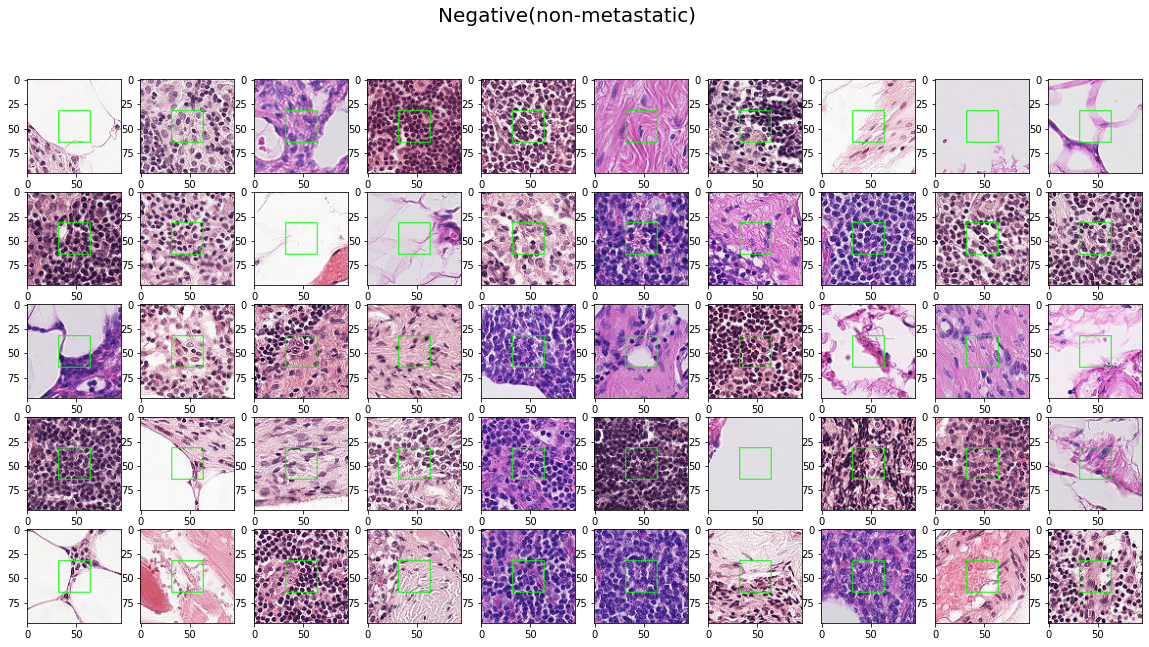

In [ ]:
# Negativeに分類される画像を最初の50個表示

nrows, ncols = 5, 10
fig, ax = plt.subplots(nrows, ncols, figsize=(20,10))
fig.suptitle('Negative(non-metastatic)',fontsize=20)

# ax[i, j]に画像を描画していく
for i in range(5):
  for j in range(10):
    # ax[i, j]に描画する画像のidは、i * 10 + j 番目のidになる。zとする
    z = i * 10 + j
    filename = nega_id[z] + ".tif"
    # imgpath と filename を結合し、画像データにアクセスするパスを作る
    join_path = os.path.join(imgpath, filename)
    # 画像の読み込み
    nega_img_ = cv2.imread(join_path)
    # BGR→RGBに変換
    nega_img = cv2.cvtColor(nega_img_, cv2.COLOR_BGR2RGB)
    # 画像の中の対象部分を正方形で囲む
    nega_img_rect = cv2.rectangle(nega_img, pt1=(32,32), pt2=(64,64), color=(0,255,0), thickness=1)
    
    # 描画  
    ax[i, j].imshow(nega_img_rect)

#### ２．Positive(metastatic)

In [ ]:
# Positiveに分類されるデータ
posi_df = train_labels.query("label == 1")
posi_df.head()

id  label
1   c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
6   a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da      1
7   7f6ccae485af121e0b6ee733022e226ee6b0c65f      1
11  c3d660212bf2a11c994e0eadff13770a9927b731      1
14  94fa32b29cc1c00403176c0795fffa3cfaa0f20e      1

In [ ]:
# Positiveに分類されるデータのidを取得
posi_id = posi_df.loc[:, "id"].values
print("posi_id.shape =", posi_id.shape)
# 最初の5個のみ表示
posi_id[:5]

posi_id.shape = (89117,)


array(['c18f2d887b7ae4f6742ee445113fa1aef383ed77',
       'a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da',
       '7f6ccae485af121e0b6ee733022e226ee6b0c65f',
       'c3d660212bf2a11c994e0eadff13770a9927b731',
       '94fa32b29cc1c00403176c0795fffa3cfaa0f20e'], dtype=object)

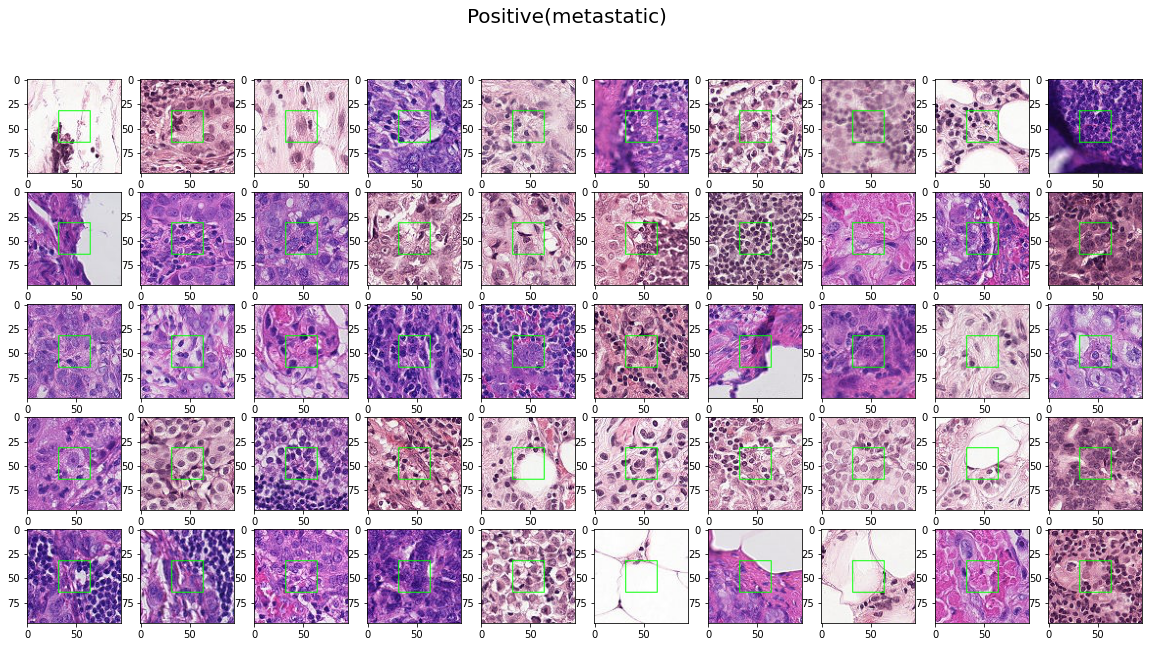

In [ ]:
# Positiveに分類される画像を最初の50個表示

nrows, ncols = 5, 10
fig, ax = plt.subplots(nrows, ncols, figsize=(20,10))
fig.suptitle('Positive(metastatic)',fontsize=20)

# ax[i, j]に画像を描画していく
for i in range(5):
  for j in range(10):
    # ax[i, j]に描画する画像のidは、i * 10 + j 番目のidになる。Zとする
    z = i * 10 + j
    filename = posi_id[z] + ".tif"
    # imgpath と filename を結合し、画像データにアクセスするパスを作る
    join_path = os.path.join(imgpath, filename)
    # 画像の読み込み
    posi_img_ = cv2.imread(join_path)
    # BGR→RGBに変換
    posi_img = cv2.cvtColor(posi_img_, cv2.COLOR_BGR2RGB)
    # 画像の中の対象部分を正方形で囲む
    posi_img_rect = cv2.rectangle(posi_img, pt1=(32,32), pt2=(64,64), color=(0,255,0), thickness=1)
    
    # 描画  
    ax[i, j].imshow(posi_img_rect)

≪考察≫

- 病理組織画像はヘマトキシリン・エオジン(HE)で染色されたリンパ節の顕微鏡画像である。 
- 濃い青色のヘマトキシリンは核酸などの負電荷を帯びた物質に、ピンク色のエオジンはアミノ酸の側鎖などの正電荷を帯びた物質に結合する。一般に**核は青色に、細胞質および細胞外はピンク色**に染まる。
- データ間で、画像の色調に大きなばらつきが認められる。これは、染色の手技のばらつきや観察時の光源の種類、フィルタのかけ方の違いなどの影響が考えられる。  
- リンパ節は、多数のリンパ球が密集した組織であり、正常なリンパ節のHE染色像としては、細胞質のほとんどない円形の核が多数見られると考えられる。また、結合組織を形成する細胞として細網細胞が存在する。   
- 転移性のがん（metastatic cancer）が見られる場合、上皮性の細胞が存在すると考えられることから、染色像としては、細胞質のある細胞、核/細胞質比率の増大したがん細胞の形態などが観察されると予想される。  
- 以上のことから、リンパ節における転移性腫瘍の有無の判定においては、細胞の形態情報（核の大きさ、核と細胞質との比率）や、ヘマトキシリンとエオジンの染色比率等が重要な特徴量になってくる可能性があると考えた。  
- ラベリングは、**画像中央の32×32pxの中で少なくとも1画素に転移性の腫瘍がある場合、Positiveに分類**される。すなわち、Negativeに分類される画像は中央の領域の外側には腫瘍を含む可能性があるため、学習は対象部分を切り出して行うほうが良いと考えた。

#### 3.（検討用）HSVでの画像確認

id  label
151577  00001b2b5609af42ab0ab276dd4cd41c3e7745b5      1

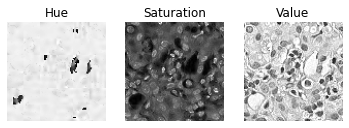

In [ ]:
# 学習用画像データを1枚取得し画像を確認
# この画像は転移性腫瘍あり
img1 = cv2.imread("/content/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif")
# BGR→HSVに変換
img1_hsv = cv2.cvtColor(img1, cv2.COLOR_BGR2HSV)

# それぞれのチャネルに分けて画像特徴を観察
h = img1_hsv[:, :, 0]
s = img1_hsv[:, :, 1]
v = img1_hsv[:, :, 2]

plt.subplot(1, 3, 1)
plt.title('Hue')
plt.imshow(h)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Saturation')
plt.imshow(s)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Value')
plt.imshow(v)
plt.axis('off')

# ラベル確認
train_labels.query("id == '00001b2b5609af42ab0ab276dd4cd41c3e7745b5'")

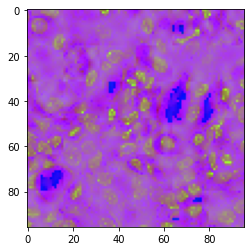

In [ ]:
plt.imshow(img1_hsv)

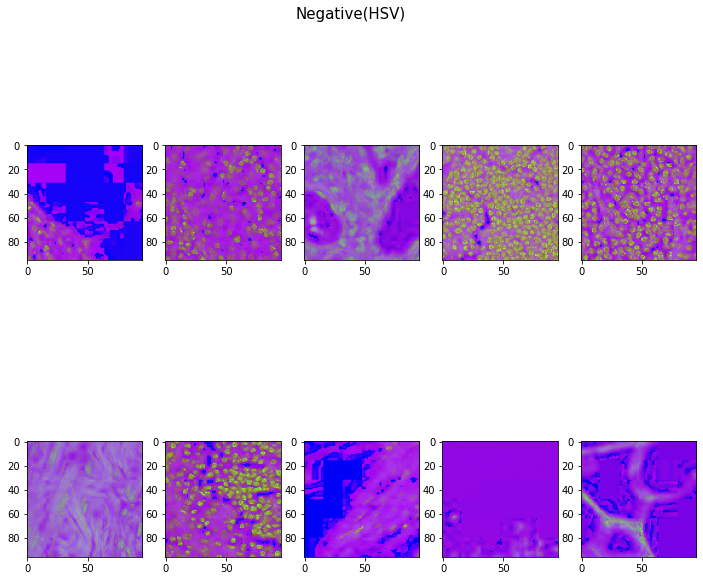

In [ ]:
# Negativeに分類される画像を最初の10個表示

nrows, ncols = 2, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(12,10))
fig.suptitle('Negative(HSV)',fontsize=15)

# ax[i, j]に画像を描画していく
for i in range(2):
  for j in range(5):
    # ax[i, j]に描画する画像のidは、i * 5 + j 番目のidになる。zとする
    z = i * 5 + j
    filename = nega_id[z] + ".tif"
    # imgpath と filename を結合し、画像データにアクセスするパスを作る
    join_path = os.path.join(imgpath, filename)
    # 画像の読み込み
    nega_img_ = cv2.imread(join_path)
    # BGR→HSVに変換
    nega_img = cv2.cvtColor(nega_img_, cv2.COLOR_BGR2HSV)
    
    # 描画  # HSV画像をimshowで表示するときは以下でいいのか？
    ax[i, j].imshow(nega_img)

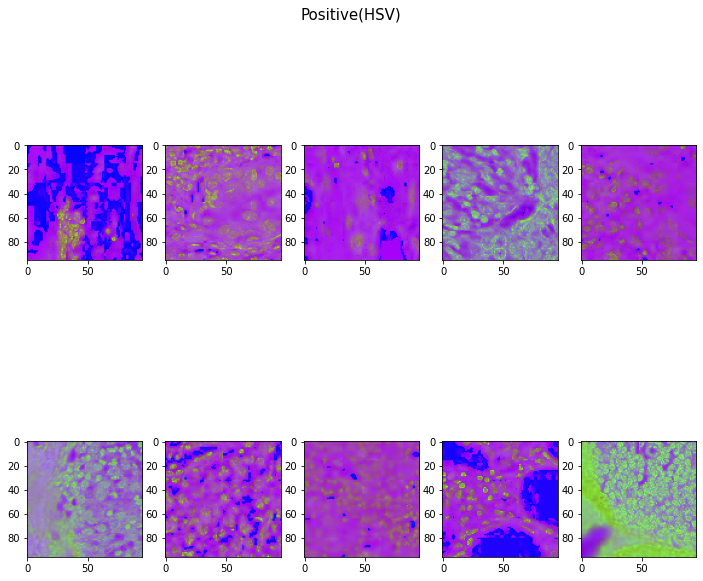

In [ ]:
# Positiveに分類される画像を最初の10個表示

nrows, ncols = 2, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(12,10))
fig.suptitle('Positive(HSV)',fontsize=15)

# ax[i, j]に画像を描画していく
for i in range(2):
  for j in range(5):
    # ax[i, j]に描画する画像のidは、i * 5 + j 番目のidになる。zとする
    z = i * 5 + j
    filename = posi_id[z] + ".tif"
    # imgpath と filename を結合し、画像データにアクセスするパスを作る
    join_path = os.path.join(imgpath, filename)
    # 画像の読み込み
    posi_img_ = cv2.imread(join_path)
    # BGR→HSVに変換
    posi_img = cv2.cvtColor(posi_img_, cv2.COLOR_BGR2HSV)
    
    # 描画
    ax[i, j].imshow(posi_img)

---

## 【ベースライン】

#### １．Data Preperation

まずはデータの水増しは行わず、色情報も残したまま機械学習にかける。  
判定に用いられる画像中央32×32pxのみを用いることとする。

In [ ]:
# 全データのidを取得
id_list = train_labels.loc[:, "id"].values
print("id_list.shape =", id_list.shape)
# 最初の5個のみ表示
id_list[:5]

id_list.shape = (220025,)


array(['f38a6374c348f90b587e046aac6079959adf3835',
       'c18f2d887b7ae4f6742ee445113fa1aef383ed77',
       '755db6279dae599ebb4d39a9123cce439965282d',
       'bc3f0c64fb968ff4a8bd33af6971ecae77c75e08',
       '068aba587a4950175d04c680d38943fd488d6a9d'], dtype=object)

In [ ]:
# 学習用の画像データが保存されているフォルダのパス
imgpath ="/content"

In [ ]:
# 画像データを格納するリストを作成する
# 判定に用いられる画像中央の32×32px部分のみを切り出したものを説明変数として用いる
# CNNでは(220025, 32, 32, 3)の形式でモデルに入力することになる

# 画像データを格納する空のリストimg_listを用意
img_list = []

# for文でid_listから1枚ずつ画像データを取得
for i in id_list:
  filename = i + ".tif"
  # imgpath と filename を結合し、画像データにアクセスするパスを作成
  join_path = os.path.join(imgpath, filename)
  # 画像の読み込み
  img_ = cv2.imread(join_path)
  # 判定に用いる中央の32×32px部分を切り抜く…(1)
  img_crop = img_[32:64, 32:64, :]
  # BGR→RGBに変換…(2)
  img = cv2.cvtColor(img_crop, cv2.COLOR_BGR2RGB)
  
  # img_listに追加
  img_list.append(img)

Memo  
(2)→(1)で処理するとRAMが一気に7GBくらいまで消費されたが、(1)crop→(2)色変換の順にすることでRAMの使用を2.63GBまで節約できた

In [ ]:
# 形状を確認
len(img_list)

220025

In [ ]:
# img_listをndarrayに変換し、データ型をuint8にする（容量節約）
img_np = np.array(img_list, dtype = np.uint8)
print("dtype:", img_np.dtype)
print("shape:", img_np.shape)

dtype: uint8
shape: (220025, 32, 32, 3)


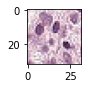

In [ ]:
# 3番目のデータで動作確認
plt.figure(figsize=(1, 1))
plt.imshow(img_np[2, :, :, :])

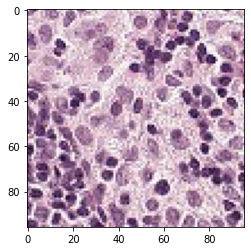

In [ ]:
# img_np[2, :, :, :]から取得した画像データがちゃんと3番目のデータになっているか
temp_id = train_labels.iloc[2, 0]
temp_filename = temp_id + ".tif"
temp_path = os.path.join(imgpath, temp_filename)

temp_img_ = img_ = cv2.imread(temp_path)
temp_img = cv2.cvtColor(temp_img_, cv2.COLOR_BGR2RGB)
plt.imshow(temp_img)
# temp_img_crop = temp_img[32:64, 32:64, :]
# plt.imshow(temp_img_crop)

説明変数(X)として用いる画像データを格納したndarray img_npを作成した

In [ ]:
# img_npをpickleモジュールでシリアライズ化
import pickle

with open("/content/drive/MyDrive/Colab Notebooks/Histopathologic Cancer Detection/img_np.pkl", "wb") as file:
  pickle.dump(img_np, file)

In [ ]:
# img_np.binのデシリアライズ化
import pickle

with open("/content/drive/MyDrive/Colab Notebooks/Histopathologic Cancer Detection/img_np.pkl", "rb") as file:
  img_np = pickle.load(file)

#### ２．CNN①

In [ ]:
# 説明変数(X)：img_np
# 目的変数(Y)：label
X = img_np
Y = train_labels["label"]

In [ ]:
# 形状の確認
print("X:", X.shape)
print("Y:", Y.shape)

X: (220025, 32, 32, 3)
Y: (220025,)


In [ ]:
# データの分割
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.3, random_state=0)

In [ ]:
# 形状を確認
print("Y_train=", Y_train.shape, ", X_train=", X_train.shape)
print("Y_valid=", Y_valid.shape, ", X_valid=", X_valid.shape)
print("Y_test=", Y_test.shape, ", X_test=", X_test.shape)

Y_train= (107811,) , X_train= (107811, 32, 32, 3)
Y_valid= (46206,) , X_valid= (46206, 32, 32, 3)
Y_test= (66008,) , X_test= (66008, 32, 32, 3)


In [ ]:
# モデルの初期化
model = keras.Sequential()

# 入力層
model.add(Conv2D(128, kernel_size=3, padding="same", strides=1, input_shape=(32, 32, 3,), activation="relu"))
model.add(Flatten())
# 隠れ層
model.add(Dense(32, activation="relu"))
# 出力層
model.add(Dense(1, activation='sigmoid'))

# モデルの構築
model.compile(optimizer = "rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# モデルの構造を表示
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 128)       3584      
                                                                 
 flatten (Flatten)           (None, 131072)            0         
                                                                 
 dense (Dense)               (None, 32)                4194336   
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,197,953
Trainable params: 4,197,953
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%%time
# 学習の実施
log = model.fit(X_train, Y_train, epochs=1000, batch_size=32, verbose=True,
                callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         min_delta=0, patience=100,
                                                         verbose=1)],
         validation_data=(X_valid, Y_valid))

Epoch 1/1000
3370/3370 [==============================] - 35s 8ms/step - loss: 3.1187 - accuracy: 0.5946 - val_loss: 0.6740 - val_accuracy: 0.5976
Epoch 2/1000
3370/3370 [==============================] - 25s 7ms/step - loss: 0.7627 - accuracy: 0.5948 - val_loss: 0.6740 - val_accuracy: 0.5976
Epoch 3/1000
3370/3370 [==============================] - 25s 7ms/step - loss: 0.8085 - accuracy: 0.5947 - val_loss: 0.6740 - val_accuracy: 0.5976
Epoch 4/1000
3370/3370 [==============================] - 23s 7ms/step - loss: 0.6751 - accuracy: 0.5948 - val_loss: 0.6740 - val_accuracy: 0.5976
Epoch 5/1000
3370/3370 [==============================] - 25s 7ms/step - loss: 0.7273 - accuracy: 0.5948 - val_loss: 0.6740 - val_accuracy: 0.5976
Epoch 6/1000
3370/3370 [==============================] - 23s 7ms/step - loss: 0.7992 - accuracy: 0.5948 - val_loss: 0.6740 - val_accuracy: 0.5976
Epoch 7/1000
3370/3370 [==============================] - 23s 7ms/step - loss: 0.7153 - accuracy: 0.5948 - val_loss: 0

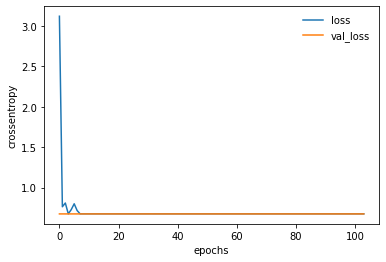

In [ ]:
# グラフ表示
plt.plot(log.history['loss'], label='loss')
plt.plot(log.history['val_loss'], label='val_loss')
plt.legend(frameon=False) # 凡例の表示
plt.xlabel("epochs")
plt.ylabel("crossentropy")
plt.show()

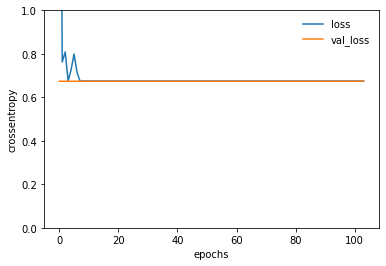

In [ ]:
# 拡大して表示
plt.plot(log.history['loss'], label='loss')
plt.plot(log.history['val_loss'], label='val_loss')
plt.legend(frameon=False) # 凡例の表示
plt.xlabel("epochs")
plt.ylabel("crossentropy")
plt.ylim(0, 1.0)
plt.show()

≪結果≫  
画像の特徴量を抽出できておらず、学習がうまくいっていないと考えられる。  
学習データに対する精度も59%と低い。  

#### ３．CNN②

In [ ]:
# 畳み込み層とプーリング層が1回ずつ、最後に全結合層を行うCNNモデルを検討する
# モデルの初期化
model2 = keras.Sequential()

# 入力層
model2.add(Conv2D(64, kernel_size=3, padding="same", strides=1, input_shape=(32, 32, 3,), activation="relu"))
# プーリング層
model2.add(MaxPooling2D(pool_size=(2, 2)))

# 一次元に変換
model2.add(Flatten())
model2.add(Dense(64, activation="relu"))

# 出力層
model2.add(Dense(1, activation='sigmoid'))

# モデルの構築
model2.compile(optimizer = "rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# モデルの構造を表示
model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 flatten_7 (Flatten)         (None, 16384)             0         
                                                                 
 dense_14 (Dense)            (None, 64)                1048640   
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 1,050,497
Trainable params: 1,050,497
Non-trainable params: 0
____________________________________________

In [ ]:
%%time
# 学習の実施
log = model2.fit(X_train, Y_train, epochs=1000, batch_size=32, verbose=True,
                callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         min_delta=0, patience=10,
                                                         verbose=1)],
         validation_data=(X_valid, Y_valid))

Epoch 1/1000
3370/3370 [==============================] - 197s 58ms/step - loss: 1.4836 - accuracy: 0.7240 - val_loss: 0.5471 - val_accuracy: 0.7287
Epoch 2/1000
3370/3370 [==============================] - 197s 58ms/step - loss: 0.5228 - accuracy: 0.7596 - val_loss: 0.5202 - val_accuracy: 0.7570
Epoch 3/1000
3370/3370 [==============================] - 189s 56ms/step - loss: 0.5238 - accuracy: 0.7581 - val_loss: 0.7058 - val_accuracy: 0.7420
Epoch 4/1000
3370/3370 [==============================] - 191s 57ms/step - loss: 0.5209 - accuracy: 0.7581 - val_loss: 0.5514 - val_accuracy: 0.7083
Epoch 5/1000
3370/3370 [==============================] - 189s 56ms/step - loss: 0.5248 - accuracy: 0.7575 - val_loss: 0.5456 - val_accuracy: 0.7201
Epoch 6/1000
3370/3370 [==============================] - 195s 58ms/step - loss: 0.5267 - accuracy: 0.7574 - val_loss: 0.6175 - val_accuracy: 0.7337
Epoch 7/1000
3370/3370 [==============================] - 190s 56ms/step - loss: 0.5274 - accuracy: 0.7575

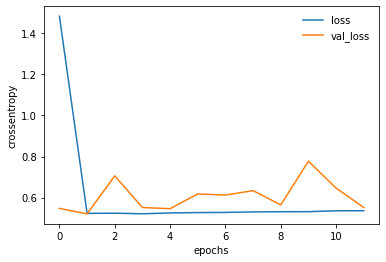

In [ ]:
# グラフ表示
plt.plot(log.history['loss'], label='loss')
plt.plot(log.history['val_loss'], label='val_loss')
plt.legend(frameon=False) # 凡例の表示
plt.xlabel("epochs")
plt.ylabel("crossentropy")
plt.show()

≪結果≫  
- Pooling層を入れることにより少し精度が向上した。  
- しかし、1つ目のモデルと同様、学習データが2エポック目以降右肩下がりになっておらず、モデルが画像の特徴をうまくつかめていないか。  

- 腫瘍の有無の判定には、画像の色が重要なのか、細胞の形態が重要なのか、特徴量として何が重要なのかわからない。  
→まずは「色調よりも、細胞の形態がより重要な特徴量である」と仮説のもと、画像をグレースケール化して学習させてみる（色調情報をカット）。

#### ４．（検討中）SVM

In [ ]:
# 画像データが格納されているimg_npから1つずつデータを取り出し、配列を1次元にする
# １次元配列に変換した画像データを格納する空のリストを用意
img_f =[]
for data in img_np:
  data_f = data.flatten()
  # img_fに追加
  img_f.append(data_f)

In [ ]:
# 形状を確認
np.shape(img_f)

(220025, 3072)

SVMの説明変数(X)として用いる画像データの配列img_fを作成した

In [ ]:
# 説明変数(X)：img_f
# 目的変数(Y)：label
X = np.array(img_f)
Y = train_labels["label"]

In [ ]:
# 形状の確認
print("X:", X.shape)
print("Y:", Y.shape)

X: (220025, 3072)
Y: (220025,)


In [ ]:
# データの分割
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.3, random_state=0)

In [ ]:
# 形状を確認
print("Y_train=", Y_train.shape, ", X_train=", X_train.shape)
print("Y_valid=", Y_valid.shape, ", X_valid=", X_valid.shape)
print("Y_test=", Y_test.shape, ", X_test=", X_test.shape)

Y_train= (107811,) , X_train= (107811, 3072)
Y_valid= (46206,) , X_valid= (46206, 3072)
Y_test= (66008,) , X_test= (66008, 3072)


In [ ]:
# SVM
svm_model = SVC(kernel="linear")
svm_model.fit(X_train, Y_train)
Y_pred = svm_model.predict(X_valid)

# モデルの評価
print(classification_report(Y_valid, Y_pred))

#### ５．ロジスティック回帰モデル

In [ ]:
# ロジスティック回帰:警告がでるため「solver='lbfgs'」を与えている
logistic_model = LogisticRegression(solver='lbfgs')
logistic_model.fit(X_train, Y_train)
Y_pred = logistic_model.predict(X_valid)

# モデルの評価
print(classification_report(Y_valid, Y_pred))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

           0       0.66      0.70      0.68     27611
           1       0.51      0.46      0.48     18595

    accuracy                           0.60     46206
   macro avg       0.58      0.58      0.58     46206
weighted avg       0.60      0.60      0.60     46206



#### ６．決定木

In [ ]:
# 決定木
tree_model = DecisionTreeClassifier(criterion='entropy')
tree_model.fit(X_train, Y_train)
Y_pred = tree_model.predict(X_valid)

# モデルの評価
print(classification_report(Y_valid, Y_pred))

              precision    recall  f1-score   support

           0       0.72      0.71      0.71     27611
           1       0.58      0.58      0.58     18595

    accuracy                           0.66     46206
   macro avg       0.65      0.65      0.65     46206
weighted avg       0.66      0.66      0.66     46206



#### ７．（検討中）ランダムフォレスト

In [ ]:
# GridSearchを用いパラメータをチューニングする

# model:ランダムフォレスト
model = RandomForestClassifier()

# parameters: n_estimators（木の数）、max_depth（木の深さ）
params = {"n_estimators": [50, 100, 500], "max_depth": [5, 10, 50]}

# GridSearch
gscv = GridSearchCV(model, param_grid=params, cv=2)  # cv=3だとかなり時間がかかったため

gscv.fit(X_train, Y_train)

時間がかかりすぎてハイパーパラメータ探索できず。

In [ ]:
# ランダムフォレスト
randomforest_model = RandomForestClassifier(n_estimators=100)
randomforest_model.fit(X_train, Y_train)
Y_pred = randomforest_model.predict(X_valid)

# モデルの評価
print(classification_report(Y_valid, Y_pred))

---

## 【モデルのブラッシュアップ】

#### １．Data Preparation　～グレースケール化～

「色調よりも、細胞の形態がより重要な特徴量である」という仮説のもと、画像をグレースケール化し、学習精度が向上するかを確認する。

In [ ]:
# Negativeに分類されるデータのidを取得
nega_df = train_labels.query("label == 0")
nega_id = nega_df.loc[:, "id"].values

# Positiveに分類されるデータのidを取得
posi_df = train_labels.query("label == 1")
posi_id = posi_df.loc[:, "id"].values

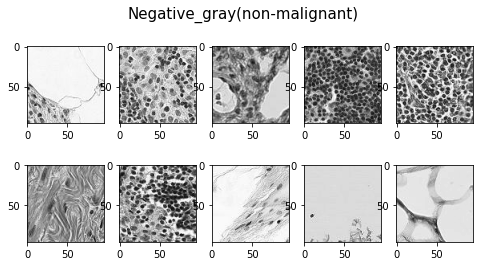

In [ ]:
# Negativeに分類される画像をグレースケールで最初の10個表示

# 学習用の画像データが保存されているフォルダのパス
imgpath ="/content"

nrows, ncols = 2, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(8,4))
fig.suptitle('Negative_gray(non-malignant)',fontsize=15)

# ax[i, j]に画像を描画していく
for i in range(2):
  for j in range(5):
    # ax[i, j]に描画する画像のidは、i * 5 + j 番目のidになる。zとする
    z = i * 5 + j
    filename = nega_id[z] + ".tif"
    # imgpath と filename を結合し、画像データにアクセスするパスを作る
    join_path = os.path.join(imgpath, filename)
    # グレースケールで画像を読み込む
    gray_nega_img_ = cv2.imread(join_path, cv2.IMREAD_GRAYSCALE)
    
    # 描画  
    ax[i, j].imshow(gray_nega_img_, cmap='gray')

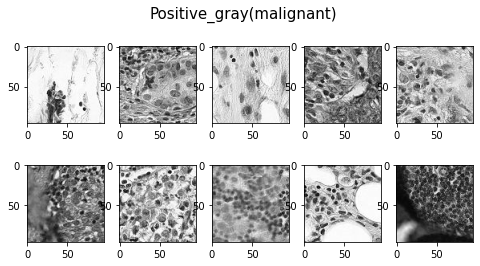

In [ ]:
# Positiveに分類される画像をグレースケールで最初の10個表示

# 学習用の画像データが保存されているフォルダのパス
imgpath ="/content"

nrows, ncols = 2, 5
fig, ax = plt.subplots(nrows, ncols, figsize=(8,4))
fig.suptitle('Positive_gray(malignant)',fontsize=15)

# ax[i, j]に画像を描画していく
for i in range(2):
  for j in range(5):
    # ax[i, j]に描画する画像のidは、i * 5 + j 番目のidになる。zとする
    z = i * 5 + j
    filename = posi_id[z] + ".tif"
    # imgpath と filename を結合し、画像データにアクセスするパスを作る
    join_path = os.path.join(imgpath, filename)
    # グレースケールで画像を読み込む
    gray_posi_img_ = cv2.imread(join_path, cv2.IMREAD_GRAYSCALE)
    
    # 描画  
    ax[i, j].imshow(gray_posi_img_, cmap='gray')

In [ ]:
# 全データのidを取得
id_list = train_labels.loc[:, "id"].values

In [ ]:
# 学習用の画像データが保存されているフォルダのパス
imgpath ="/content"

In [ ]:
# グレースケース化した画像データを格納するリストを作成する
# 判定に用いられる画像中央の32×32px部分のみを切り出したものを説明変数として用いる
# CNNでは(220025, 32, 32, 1)の形式でモデルに入力することになる

# 画像データを格納する空のリストimg_listを用意
gray_list = []

# for文でid_listから1枚ずつ画像データを取得
for i in id_list:
  filename = i + ".tif"
  # imgpath と filename を結合し、画像データにアクセスするパスを作成
  join_path = os.path.join(imgpath, filename)
  # グレースケールで画像を読み込む
  gray_img_ = cv2.imread(join_path, cv2.IMREAD_GRAYSCALE)
  # 判定に用いる中央の32×32px部分を切り抜く
  gray_crop = gray_img_[32:64, 32:64]
  
  # img_listに追加
  gray_list.append(gray_crop)

In [ ]:
# img_listをndarrayに変換し、データ型と形状を確認
gray_np = np.array(gray_list)
print("dtype:", gray_np.dtype)
print("shape:", gray_np.shape)

dtype: uint8
shape: (220025, 32, 32)


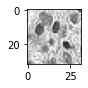

In [ ]:
# 3番目のデータで動作確認
plt.figure(figsize=(1, 1))
plt.imshow(gray_np[2, :, :], cmap='gray')

説明変数(X)として用いるグレースケール化した画像データを格納したndarray gray_npを作成した

#### ２．CNN

In [ ]:
# 説明変数(X)：gray_np
# 目的変数(Y)：label
X = gray_np.reshape(len(gray_list), 32, 32, 1)
Y = train_labels["label"]

In [ ]:
# 形状の確認
print("X:", X.shape)
print("Y:", Y.shape)

X: (220025, 32, 32, 1)
Y: (220025,)


In [ ]:
# データの分割
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.3, random_state=0)

In [ ]:
# 形状を確認
print("Y_train=", Y_train.shape, ", X_train=", X_train.shape)
print("Y_valid=", Y_valid.shape, ", X_valid=", X_valid.shape)
print("Y_test=", Y_test.shape, ", X_test=", X_test.shape)

Y_train= (107811,) , X_train= (107811, 32, 32, 1)
Y_valid= (46206,) , X_valid= (46206, 32, 32, 1)
Y_test= (66008,) , X_test= (66008, 32, 32, 1)


In [ ]:
# 畳み込み層とプーリング層が1回ずつ、最後に全結合層を行うCNNモデルを検討する
# モデルの初期化
model = keras.Sequential()

# 入力層
model.add(Conv2D(64, kernel_size=3, padding="same", strides=1, input_shape=(32, 32, 1,), activation="relu"))
# プーリング層
model.add(MaxPooling2D(pool_size=(2, 2)))

# 一次元に変換
model.add(Flatten())
model.add(Dense(64, activation="relu"))

# 出力層
model.add(Dense(1, activation='sigmoid'))

# モデルの構築
model.compile(optimizer = "rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# モデルの構造を表示
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 64)                1048640   
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,049,345
Trainable params: 1,049,345
Non-trainable params: 0
______________________________________________

In [ ]:
%%time
# 学習の実施
log = model.fit(X_train, Y_train, epochs=1000, batch_size=32, verbose=True,
                callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         min_delta=0, patience=100,
                                                         verbose=1)],
         validation_data=(X_valid, Y_valid))

Epoch 1/1000
3370/3370 [==============================] - 27s 5ms/step - loss: 0.9128 - accuracy: 0.7091 - val_loss: 0.5972 - val_accuracy: 0.7024
Epoch 2/1000
3370/3370 [==============================] - 19s 6ms/step - loss: 0.5383 - accuracy: 0.7390 - val_loss: 0.5546 - val_accuracy: 0.7199
Epoch 3/1000
3370/3370 [==============================] - 18s 5ms/step - loss: 0.5331 - accuracy: 0.7418 - val_loss: 0.5283 - val_accuracy: 0.7428
Epoch 4/1000
3370/3370 [==============================] - 17s 5ms/step - loss: 0.5318 - accuracy: 0.7430 - val_loss: 0.7532 - val_accuracy: 0.6150
Epoch 5/1000
3370/3370 [==============================] - 19s 6ms/step - loss: 0.5313 - accuracy: 0.7432 - val_loss: 0.5640 - val_accuracy: 0.7325
Epoch 6/1000
3370/3370 [==============================] - 19s 6ms/step - loss: 0.5314 - accuracy: 0.7425 - val_loss: 0.5344 - val_accuracy: 0.7338
Epoch 7/1000
3370/3370 [==============================] - 19s 6ms/step - loss: 0.5262 - accuracy: 0.7442 - val_loss: 0

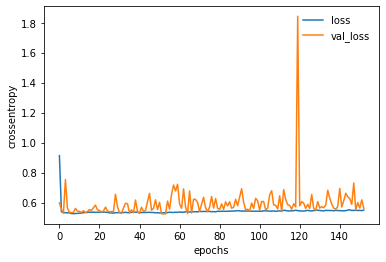

In [ ]:
# グラフ表示
plt.plot(log.history['loss'], label='loss')
plt.plot(log.history['val_loss'], label='val_loss')
plt.legend(frameon=False) # 凡例の表示
plt.xlabel("epochs")
plt.ylabel("crossentropy")
plt.show()

≪結果≫  
- ベースラインよりも精度が下がった。 
- 色調の情報も特徴量として残したほうがよい可能性がある。  
- より形態に着目させるため、画像の反転や回転によりデータの水増しを行い、学習させてみる。  
- 効率化のため、引き続きグレースケールのまま、データの水増しを試すこととする。

#### ３．Data Preparation　～Affine変換によるデータの水増し（グレースケール画像）～

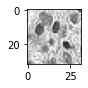

In [ ]:
# 3番目のデータで動作確認
gray_img_3 = gray_np[2, :, :]
plt.figure(figsize=(1, 1))
plt.imshow(gray_img_3, cmap='gray')

In [ ]:
# getRotateMatrix2D() 関数で反時計回りに90度回転(M1)、180度回転(M2)させるための変換行列を求める
# 回転の中心座標を画像の中心とする

# 元画像のサイズを取得
h, w = gray_img_3.shape
print("h=", h, "w=", w)

# 変換行列を取得
M1 = cv2.getRotationMatrix2D((w/2, h/2), 90, 1)
M2 = cv2.getRotationMatrix2D((w/2, h/2), 180, 1)

h= 32 w= 32


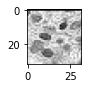

In [ ]:
# 求めた回転行列でアフィン変換する
gray_img_3_rot90 = cv2.warpAffine(gray_img_3, M1, (32, 32))
plt.figure(figsize=(1, 1))
plt.imshow(gray_img_3_rot90, cmap="gray")

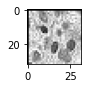

In [ ]:
# 求めた回転行列でアフィン変換する
gray_img_3_rot180 = cv2.warpAffine(gray_img_3, M2, (32, 32))
plt.figure(figsize=(1, 1))
plt.imshow(gray_img_3_rot180, cmap="gray")

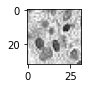

In [ ]:
# 上下反転
gray_img_3_ud = cv2.flip(gray_img_3, 0)
plt.figure(figsize=(1, 1))
plt.imshow(gray_img_3_ud, cmap="gray")

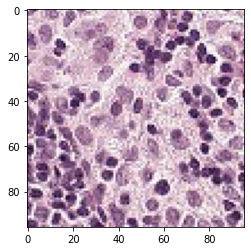

In [ ]:
# 3番目のデータで動作確認
temp_id = train_labels.iloc[2, 0]
temp_filename = temp_id + ".tif"
temp_path = os.path.join(imgpath, temp_filename)

temp_img_ = img_ = cv2.imread(temp_path)
temp_img = cv2.cvtColor(temp_img_, cv2.COLOR_BGR2RGB)
plt.imshow(temp_img)

In [ ]:
# getRotateMatrix2D() 関数で反時計回りに90度回転(M1)、180度回転(M2)させるための変換行列を求める
# 回転の中心座標を画像の中心とする

# 元画像のサイズを取得
h, w, c = temp_img.shape
print("h=", h, "w=", w, "c=", c)

# 変換行列を取得
M1 = cv2.getRotationMatrix2D((w/2, h/2), 90, 1)
M2 = cv2.getRotationMatrix2D((w/2, h/2), 180, 1)

h= 96 w= 96 c= 3


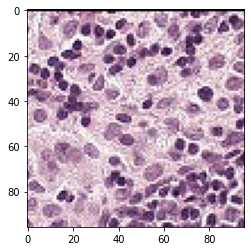

In [ ]:
# 求めた回転行列でアフィン変換する
temp_img_rot90 = cv2.warpAffine(temp_img, M1, (96, 96))
plt.imshow(temp_img_rot90)

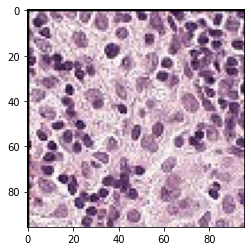

In [ ]:
# 求めた回転行列でアフィン変換する
temp_img_rot180 = cv2.warpAffine(temp_img, M2, (96, 96))
plt.imshow(temp_img_rot180)

【修正】並べて表示するようにする

In [ ]:
# 全データのidを取得
id_list = train_labels.loc[:, "id"].values

# 学習用の画像データが保存されているフォルダのパス
imgpath ="/content" 

In [ ]:
# getRotateMatrix2D() 関数で反時計回りに90度回転(M1)、180度回転(M2)させるための変換行列を求める
# 回転の中心座標を画像の中心とする(32×32px画像の中心)
# 変換行列を取得
M1 = cv2.getRotationMatrix2D((32/2, 32/2), 90, 1)
M2 = cv2.getRotationMatrix2D((32/2, 32/2), 180, 1)

In [ ]:
# グレースケース化した画像データの読み込み（画像中央の32×32px部分のみ用いる）
# 1つのデータから以下の5パターンのデータを作成し、水増しを行う
# 元データ、左右反転、上下反転、90度回転、180度回転

# ndarrayのデータを保管する領域の確保
data_count = train_labels["id"].count()
# 1つのデータから5パターン生成するため、5倍の容量を確保する
grayimg_dg5 = np.empty((data_count * 5, 32, 32), dtype=np.uint8)
label_dg5 = np.empty((data_count * 5), dtype=np.uint8)   

# for文でid_listから1枚ずつ画像データを取得
for i, id in enumerate(id_list, 0):

  # 元の画像をグレースケールで読み込んでgrayimg_dg5に追加
  filename = id + ".tif"
  join_path = os.path.join(imgpath, filename)
  gray_img_ = cv2.imread(join_path, cv2.IMREAD_GRAYSCALE)
  gray_img = gray_img_[32:64, 32:64]
  grayimg_dg5[i] = gray_img
  label_dg5[i] = train_labels.loc[i, "label"]
  
  # 左右反転した画像を追加
  gray_img_lr = cv2.flip(gray_img, 1)
  grayimg_dg5[i + data_count] = gray_img_lr
  label_dg5[i + data_count] = train_labels.loc[i, "label"]

  # 上下反転した画像を追加
  gray_img_ud = cv2.flip(gray_img, 0)
  grayimg_dg5[i + data_count * 2] = gray_img_ud
  label_dg5[i + data_count * 2] = train_labels.loc[i, "label"]
  
  # 90度回転した画像を追加
  gray_img_rot90 = cv2.warpAffine(gray_img, M1, (32, 32))
  grayimg_dg5[i + data_count * 3] = gray_img_rot90
  label_dg5[i + data_count * 3] = train_labels.loc[i, "label"]

  # 180度回転した画像を追加
  gray_img_rot180 = cv2.warpAffine(gray_img, M2, (32, 32))
  grayimg_dg5[i + data_count * 4] = gray_img_rot180
  label_dg5[i + data_count * 4] = train_labels.loc[i, "label"]

In [ ]:
# 形状を確認
print("grayimg_dg5:", grayimg_dg5.shape)
print("label_dg5:", label_dg5.shape)

grayimg_dg5: (1100125, 32, 32)
label_dg5: (1100125,)


In [ ]:
# データ量の確認
a = 32 * 32 * 1 * 220025 * 5
print(a, "bytes")
print(a/1024/1024/1024, "GB")

1126528000 bytes
1.0491609573364258 GB


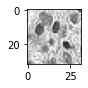

In [ ]:
# 3番目のデータで動作確認
plt.figure(figsize=(1, 1))
plt.imshow(grayimg_dg5[2], cmap="gray")

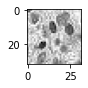

In [ ]:
plt.figure(figsize=(1, 1))
plt.imshow(grayimg_dg5[2 + data_count], cmap="gray")

In [ ]:
label_dg5[2]

0

グレースケール化し、5パターンに水増しした全画像データを格納したndarray grayimg_dg5を作成した

【オブジェクトをpickle化】

In [ ]:
# grayimg_dg5をpickleモジュールでシリアライズ化
import pickle

with open("/content/drive/MyDrive/Colab Notebooks/Histopathologic Cancer Detection/grayimg_dg5.pkl", "wb") as file:
  pickle.dump(grayimg_dg5, file)

In [ ]:
# label_dg5をpickleモジュールでシリアライズ化
with open("/content/drive/MyDrive/Colab Notebooks/Histopathologic Cancer Detection/label_dg5.pkl", "wb") as file:
  pickle.dump(label_dg5, file)

In [ ]:
# grayimg_dg5.pklのデシリアライズ化
import pickle

with open("/content/drive/MyDrive/Colab Notebooks/Histopathologic Cancer Detection/grayimg_dg5.pkl", "rb") as file:
  grayimg_dg5 = pickle.load(file)

In [ ]:
# label_dg5.pklのデシリアライズ化
import pickle

with open("/content/drive/MyDrive/Colab Notebooks/Histopathologic Cancer Detection/label_dg5.pkl", "rb") as file:
  label_dg5 = pickle.load(file)

#### ４．CNN

In [ ]:
# 説明変数(X)：grayimg_dg5
# 目的変数(Y)：label_dg5
X = grayimg_dg5.reshape(data_count * 5, 32, 32, 1)
Y = label_dg5

In [ ]:
# 形状を確認
print("X:", X.shape)
print("Y:", Y.shape)

X: (1100125, 32, 32, 1)
Y: (1100125,)


In [ ]:
# データの分割
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.3, random_state=0)

In [ ]:
# 形状を確認
print("Y_train=", Y_train.shape, ", X_train=", X_train.shape)
print("Y_valid=", Y_valid.shape, ", X_valid=", X_valid.shape)
print("Y_test=", Y_test.shape, ", X_test=", X_test.shape)

Y_train= (539060,) , X_train= (539060, 32, 32, 1)
Y_valid= (231027,) , X_valid= (231027, 32, 32, 1)
Y_test= (330038,) , X_test= (330038, 32, 32, 1)


In [ ]:
# 畳み込み層とプーリング層が1回ずつ、最後に全結合層を行うCNNモデルを検討する
# モデルの初期化
model = keras.Sequential()

# 入力層
model.add(Conv2D(64, kernel_size=3, padding="same", strides=1, input_shape=(32, 32, 1,), activation="relu"))
# プーリング層
model.add(MaxPooling2D(pool_size=(2, 2)))

# 一次元に変換
model.add(Flatten())
model.add(Dense(64, activation="relu"))

# 出力層
model.add(Dense(1, activation='sigmoid'))

# モデルの構築
model.compile(optimizer = "rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# モデルの構造を表示
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        640       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 16384)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                1048640   
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,049,345
Trainable params: 1,049,345
Non-trainable params: 0
____________________________________________

In [ ]:
%%time
# 学習の実施
log = model.fit(X_train, Y_train, epochs=1000, batch_size=32, verbose=True,
                callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         min_delta=0, patience=10,
                                                         verbose=1)],
         validation_data=(X_valid, Y_valid))

Epoch 1/1000
16846/16846 [==============================] - 836s 50ms/step - loss: 0.7849 - accuracy: 0.7280 - val_loss: 0.5354 - val_accuracy: 0.7400
Epoch 2/1000
16846/16846 [==============================] - 810s 48ms/step - loss: 0.5332 - accuracy: 0.7404 - val_loss: 0.5344 - val_accuracy: 0.7318
Epoch 3/1000
16846/16846 [==============================] - 832s 49ms/step - loss: 0.5306 - accuracy: 0.7421 - val_loss: 0.5438 - val_accuracy: 0.7298
Epoch 4/1000
16846/16846 [==============================] - 836s 50ms/step - loss: 0.5298 - accuracy: 0.7434 - val_loss: 0.5346 - val_accuracy: 0.7329
Epoch 5/1000
16846/16846 [==============================] - 817s 48ms/step - loss: 0.5316 - accuracy: 0.7418 - val_loss: 0.5312 - val_accuracy: 0.7439
Epoch 6/1000
16846/16846 [==============================] - 813s 48ms/step - loss: 0.5325 - accuracy: 0.7419 - val_loss: 0.5394 - val_accuracy: 0.7495
Epoch 7/1000
16846/16846 [==============================] - 848s 50ms/step - loss: 0.5335 - ac

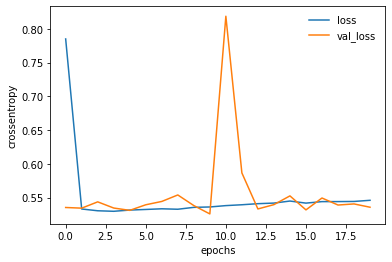

In [ ]:
# グラフ表示
plt.plot(log.history['loss'], label='loss')
plt.plot(log.history['val_loss'], label='val_loss')
plt.legend(frameon=False) # 凡例の表示
plt.xlabel("epochs")
plt.ylabel("crossentropy")
plt.show()

≪結果≫  
- 学習データの損失関数の値が右肩上がりになってしまっている。  
- 水増しの効果が見られていない。グレースケース画像では、学習が不十分であると考えられる。  
- 再度、RGBカラー画像に戻し、水増しを行って精度が向上するか確認する。

#### ５．Data Preparation　～Affine変換によるデータの水増し（RGB画像）～

In [ ]:
# 全データのidを取得
id_list = train_labels.loc[:, "id"].values

# 学習用の画像データが保存されているフォルダのパス
imgpath ="/content" 

In [ ]:
# getRotateMatrix2D() 関数で反時計回りに90度回転(M1)、180度回転(M2)させるための変換行列を求める
# 回転の中心座標を画像の中心とする(32×32px画像の中心)
# 変換行列を取得
M1 = cv2.getRotationMatrix2D((32/2, 32/2), 90, 1)
M2 = cv2.getRotationMatrix2D((32/2, 32/2), 180, 1)

In [ ]:
# 画像データの読み込み（画像中央の32×32px部分のみ用いる）
# 1つのデータから以下の3パターンのデータを作成し、水増しを行う
# 元データ、90度回転、180度回転

# ndarrayのデータを保管する領域の確保
data_count = train_labels["id"].count()
# 1つのデータから3パターン生成するため、3倍の容量を確保する
img_dg3 = np.empty((data_count * 3, 32, 32, 3), dtype=np.uint8)
label_dg3 = np.empty((data_count * 3), dtype=np.uint8)   

# for文でid_listから1枚ずつ画像データを取得
for i, id in enumerate(id_list, 0):

  # 元の画像を読み込みimg_dg3に追加
  filename = id + ".tif"
  join_path = os.path.join(imgpath, filename)
  img_ = cv2.imread(join_path)
  img = cv2.cvtColor(img_, cv2.COLOR_BGR2RGB)
  img_crop = img[32:64, 32:64]
  img_dg3[i] = img_crop
  label_dg3[i] = train_labels.loc[i, "label"]
  
  # 90度回転した画像を追加
  img_crop_rot90 = cv2.warpAffine(img_crop, M1, (32, 32))
  img_dg3[i + data_count] = img_crop_rot90
  label_dg3[i + data_count] = train_labels.loc[i, "label"]

  # 180度回転した画像を追加
  img_crop_rot180 = cv2.warpAffine(img_crop, M2, (32, 32))
  img_dg3[i + data_count * 2] = img_crop_rot180
  label_dg3[i + data_count * 2] = train_labels.loc[i, "label"]

  del img_

In [ ]:
# 形状を確認
print("img_dg3:", img_dg3.shape)
print("label_dg3:", label_dg3.shape)

img_dg3: (660075, 32, 32, 3)
label_dg3: (660075,)


【オブジェクトをpickle化】

In [ ]:
# img_dg3をpickleモジュールでシリアライズ化
import pickle

with open("/content/drive/MyDrive/Colab Notebooks/Histopathologic Cancer Detection/img_dg3.pkl", "wb") as file:
  pickle.dump(img_dg3, file)

In [ ]:
# label_dg3をpickleモジュールでシリアライズ化
with open("/content/drive/MyDrive/Colab Notebooks/Histopathologic Cancer Detection/label_dg3.pkl", "wb") as file:
  pickle.dump(label_dg3, file)

In [ ]:
# img_dg3.pklのデシリアライズ化
import pickle

with open("/content/drive/MyDrive/Colab Notebooks/Histopathologic Cancer Detection/img_dg3.pkl", "rb") as file:
  img_dg3 = pickle.load(file)

In [ ]:
# label_dg3.pklのデシリアライズ化
import pickle

with open("/content/drive/MyDrive/Colab Notebooks/Histopathologic Cancer Detection/label_dg3.pkl", "rb") as file:
  label_dg3 = pickle.load(file)

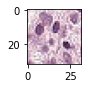

In [ ]:
# 3番目のデータで動作確認
plt.figure(figsize=(1, 1))
plt.imshow(img_dg3[2])

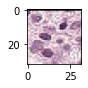

In [ ]:
plt.figure(figsize=(1, 1))
plt.imshow(img_dg3[2 + 220025])

In [ ]:
label_dg3[2]

0

#### ６．CNN

In [ ]:
# 説明変数(X)：img_dg3
# 目的変数(Y)：label_dg3
X = img_dg3
Y = label_dg3

In [ ]:
# 形状を確認
print("X:", X.shape)
print("Y:", Y.shape)

X: (660075, 32, 32, 3)
Y: (660075,)


In [ ]:
# データの分割
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.3, random_state=0)

In [ ]:
# 形状を確認
print("Y_train=", Y_train.shape, ", X_train=", X_train.shape)
print("Y_valid=", Y_valid.shape, ", X_valid=", X_valid.shape)
print("Y_test=", Y_test.shape, ", X_test=", X_test.shape)

Y_train= (323436,) , X_train= (323436, 32, 32, 3)
Y_valid= (138616,) , X_valid= (138616, 32, 32, 3)
Y_test= (198023,) , X_test= (198023, 32, 32, 3)


In [ ]:
# 畳み込み層とプーリング層が1回ずつ、最後に全結合層を行うCNNモデルを検討する
# モデルの初期化
model = keras.Sequential()

# 入力層
model.add(Conv2D(64, kernel_size=3, padding="same", strides=1, input_shape=(32, 32, 3,), activation="relu"))
# プーリング層
model.add(MaxPooling2D(pool_size=(2, 2)))

# 一次元に変換
model.add(Flatten())
model.add(Dense(64, activation="relu"))

# 出力層
model.add(Dense(1, activation='sigmoid'))

# モデルの構築
model.compile(optimizer = "rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# モデルの構造を表示
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 16384)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                1048640   
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,050,497
Trainable params: 1,050,497
Non-trainable params: 0
____________________________________________

In [ ]:
%%time
# 学習の実施
log = model.fit(X_train, Y_train, epochs=1000, batch_size=32, verbose=True,
                callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         min_delta=0, patience=10,
                                                         verbose=1)],
         validation_data=(X_valid, Y_valid))

Epoch 1/1000
10108/10108 [==============================] - 69s 6ms/step - loss: 1.1072 - accuracy: 0.7441 - val_loss: 0.5648 - val_accuracy: 0.7168
Epoch 2/1000
10108/10108 [==============================] - 57s 6ms/step - loss: 0.5245 - accuracy: 0.7587 - val_loss: 0.5096 - val_accuracy: 0.7629
Epoch 3/1000
10108/10108 [==============================] - 66s 7ms/step - loss: 0.5265 - accuracy: 0.7602 - val_loss: 0.6789 - val_accuracy: 0.7511
Epoch 4/1000
10108/10108 [==============================] - 56s 6ms/step - loss: 0.5330 - accuracy: 0.7598 - val_loss: 0.5073 - val_accuracy: 0.7660
Epoch 5/1000
10108/10108 [==============================] - 56s 6ms/step - loss: 0.5343 - accuracy: 0.7588 - val_loss: 0.7842 - val_accuracy: 0.6966
Epoch 6/1000
10108/10108 [==============================] - 58s 6ms/step - loss: 0.5297 - accuracy: 0.7591 - val_loss: 0.6241 - val_accuracy: 0.7132
Epoch 7/1000
10108/10108 [==============================] - 56s 6ms/step - loss: 0.5349 - accuracy: 0.7596

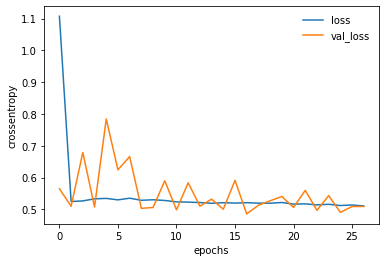

In [ ]:
# グラフ表示
plt.plot(log.history['loss'], label='loss')
plt.plot(log.history['val_loss'], label='val_loss')
plt.legend(frameon=False) # 凡例の表示
plt.xlabel("epochs")
plt.ylabel("crossentropy")
plt.show()

≪結果≫  
- validation lossは暴れているが、lossが右肩下がりに下がり、うまく学習が進んでいると考えられる。  
- モデルを多層化することによって精度の向上に繋がるか確認してみる。
- 正則化を入れることによってvalidation lossを落ち着かせることができるか試してみる。

#### ７．CNN（多層化）

In [ ]:
# 畳み込み層とプーリング層を2回繰り返し、最後に全結合層を行うCNNモデルを検討する
# モデルの初期化
model = keras.Sequential()

# 入力層
model.add(Conv2D(64, kernel_size=3, padding="same", strides=1, input_shape=(32, 32, 3,), activation="relu"))
# プーリング層
model.add(MaxPooling2D(pool_size=(2, 2)))

# 層の繰り返し
model.add(Conv2D(128, kernel_size=3, padding="same", strides=1, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 一次元に変換
model.add(Flatten())
model.add(Dense(64, activation="relu"))

# 出力層
model.add(Dense(1, activation='sigmoid'))

# モデルの構築
model.compile(optimizer = "rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# モデルの構造を表示
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [ ]:
%%time
# 学習の実施
log = model.fit(X_train, Y_train, epochs=1000, batch_size=32, verbose=True,
                callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         min_delta=0, patience=10,
                                                         verbose=1)],
         validation_data=(X_valid, Y_valid))

Epoch 1/1000
10108/10108 [==============================] - 62s 6ms/step - loss: 0.6666 - accuracy: 0.7493 - val_loss: 0.5261 - val_accuracy: 0.7448
Epoch 2/1000
10108/10108 [==============================] - 71s 7ms/step - loss: 0.5202 - accuracy: 0.7651 - val_loss: 0.4976 - val_accuracy: 0.7665
Epoch 3/1000
10108/10108 [==============================] - 62s 6ms/step - loss: 0.5272 - accuracy: 0.7668 - val_loss: 0.5073 - val_accuracy: 0.7707
Epoch 4/1000
10108/10108 [==============================] - 60s 6ms/step - loss: 0.5292 - accuracy: 0.7635 - val_loss: 0.5332 - val_accuracy: 0.7599
Epoch 5/1000
10108/10108 [==============================] - 71s 7ms/step - loss: 0.5342 - accuracy: 0.7636 - val_loss: 0.5005 - val_accuracy: 0.7725
Epoch 6/1000
10108/10108 [==============================] - 69s 7ms/step - loss: 0.5330 - accuracy: 0.7644 - val_loss: 0.5657 - val_accuracy: 0.7499
Epoch 7/1000
10108/10108 [==============================] - 71s 7ms/step - loss: 0.5319 - accuracy: 0.7619

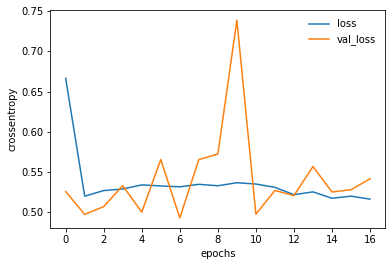

In [ ]:
# グラフ表示
plt.plot(log.history['loss'], label='loss')
plt.plot(log.history['val_loss'], label='val_loss')
plt.legend(frameon=False) # 凡例の表示
plt.xlabel("epochs")
plt.ylabel("crossentropy")
plt.show()

#### ８．CNN（多層化②）

In [ ]:
# さらに層を繰り返す
# モデルの初期化
model = keras.Sequential()

# 入力層
model.add(Conv2D(64, kernel_size=3, padding="same", strides=1, input_shape=(32, 32, 3,), activation="relu"))
# プーリング層
model.add(MaxPooling2D(pool_size=(2, 2)))

# 層の繰り返し
model.add(Conv2D(128, kernel_size=3, padding="same", strides=1, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 層の繰り返し
model.add(Conv2D(128, kernel_size=3, padding="same", strides=1, activation="relu"))
model.add(MaxPooling2D(pool_size=(2, 2)))

# 一次元に変換
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(32, activation="relu"))

# 出力層
model.add(Dense(1, activation='sigmoid'))

# モデルの構築
model.compile(optimizer = "rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# モデルの構造を表示
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4, 4, 128)       

In [ ]:
%%time
# 学習の実施
log = model.fit(X_train, Y_train, epochs=1000, batch_size=32, verbose=True,
                callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         min_delta=0, patience=10,
                                                         verbose=1)],
         validation_data=(X_valid, Y_valid))

Epoch 1/1000
10108/10108 [==============================] - 72s 7ms/step - loss: 0.5675 - accuracy: 0.7543 - val_loss: 0.6448 - val_accuracy: 0.7306
Epoch 2/1000
10108/10108 [==============================] - 73s 7ms/step - loss: 0.5242 - accuracy: 0.7670 - val_loss: 0.5002 - val_accuracy: 0.7796
Epoch 3/1000
10108/10108 [==============================] - 78s 8ms/step - loss: 0.5338 - accuracy: 0.7682 - val_loss: 0.7734 - val_accuracy: 0.6901
Epoch 4/1000
10108/10108 [==============================] - 70s 7ms/step - loss: 0.5613 - accuracy: 0.7699 - val_loss: 0.6734 - val_accuracy: 0.6968
Epoch 5/1000
10108/10108 [==============================] - 69s 7ms/step - loss: 0.5936 - accuracy: 0.7662 - val_loss: 0.5272 - val_accuracy: 0.7617
Epoch 6/1000
10108/10108 [==============================] - 80s 8ms/step - loss: 0.5893 - accuracy: 0.7673 - val_loss: 0.7075 - val_accuracy: 0.7518
Epoch 7/1000
10108/10108 [==============================] - 71s 7ms/step - loss: 0.6204 - accuracy: 0.7616

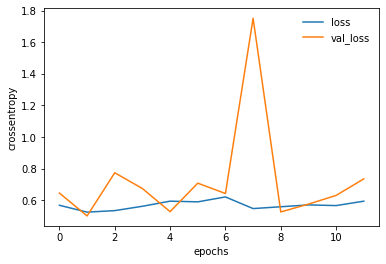

In [ ]:
# グラフ表示
plt.plot(log.history['loss'], label='loss')
plt.plot(log.history['val_loss'], label='val_loss')
plt.legend(frameon=False) # 凡例の表示
plt.xlabel("epochs")
plt.ylabel("crossentropy")
plt.show()

≪結果≫  
層を深くする効果は見られない。

#### ９．CNN（L1正則化）

In [ ]:
# 畳み込み層とプーリング層が1回ずつ、最後に全結合層を行うCNNモデルを検討する
# モデルの初期化
model = keras.Sequential()

# 入力層
model.add(Conv2D(64, kernel_size=3, padding="same", strides=1, input_shape=(32, 32, 3,), activation="relu"))
# プーリング層
model.add(MaxPooling2D(pool_size=(2, 2)))

# 一次元に変換
model.add(Flatten())
model.add(Dense(64, activation="relu", kernel_regularizer=regularizers.l1(0.001)))

# 出力層
model.add(Dense(1, activation='sigmoid'))

# モデルの構築
model.compile(optimizer = "rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# モデルの構造を表示
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 16384)             0         
                                                                 
 dense_2 (Dense)             (None, 64)                1048640   
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,050,497
Trainable params: 1,050,497
Non-trainable params: 0
____________________________________________

In [ ]:
%%time
# 学習の実施
log = model.fit(X_train, Y_train, epochs=1000, batch_size=32, verbose=True,
                callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         min_delta=0, patience=10,
                                                         verbose=1)],
         validation_data=(X_valid, Y_valid))

Epoch 1/1000
10108/10108 [==============================] - 636s 63ms/step - loss: 1.3784 - accuracy: 0.7445 - val_loss: 1.0042 - val_accuracy: 0.7646
Epoch 2/1000
10108/10108 [==============================] - 634s 63ms/step - loss: 1.0202 - accuracy: 0.7603 - val_loss: 1.0246 - val_accuracy: 0.7580
Epoch 3/1000
10108/10108 [==============================] - 641s 63ms/step - loss: 1.0171 - accuracy: 0.7628 - val_loss: 1.0063 - val_accuracy: 0.7652
Epoch 4/1000
10108/10108 [==============================] - 626s 62ms/step - loss: 1.0130 - accuracy: 0.7646 - val_loss: 1.0117 - val_accuracy: 0.7697
Epoch 5/1000
10108/10108 [==============================] - 636s 63ms/step - loss: 1.0125 - accuracy: 0.7658 - val_loss: 1.0052 - val_accuracy: 0.7674
Epoch 6/1000
10108/10108 [==============================] - 636s 63ms/step - loss: 1.0116 - accuracy: 0.7658 - val_loss: 1.0056 - val_accuracy: 0.7649
Epoch 7/1000
10108/10108 [==============================] - 625s 62ms/step - loss: 1.0111 - ac

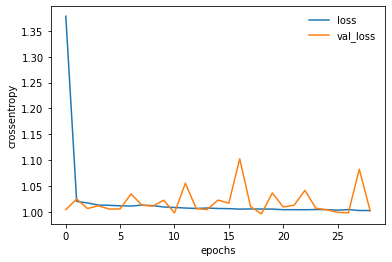

In [ ]:
# グラフ表示
loss = np.array([1.3784, 1.0202, 1.0171, 1.0130, 1.0125, 1.0116, 1.0111, 1.0129, 1.0119, 1.0093, 1.0084, 1.0073, 1.0064, 1.0073, 1.0064, 1.0061, 1.0052, 1.0055, 1.0054, 1.0052, 1.0041, 1.0041, 1.0040, 1.0044, 1.0042, 1.0031, 1.0043, 1.0025, 1.0024])
val_loss = np.array([1.0042, 1.0246, 1.0063, 1.0117, 1.0052, 1.0056, 1.0347, 1.0128, 1.0110, 1.0224, 0.9979, 1.0553, 1.0063, 1.0044, 1.0226, 1.0168, 1.1025, 1.0100, 0.9959, 1.0366, 1.0094, 1.0126, 1.0415, 1.0070, 1.0039, 0.9989, 0.9982, 1.0823, 1.0019])
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend(frameon=False) # 凡例の表示
plt.xlabel("epochs")
plt.ylabel("crossentropy")
plt.show()

≪結果≫  
val_lossが暴れていたところが、少し改善された。

#### １０．CNN（L2正則化）

In [ ]:
# 畳み込み層とプーリング層が1回ずつ、最後に全結合層を行うCNNモデルを検討する
# モデルの初期化
model = keras.Sequential()

# 入力層
model.add(Conv2D(64, kernel_size=3, padding="same", strides=1, input_shape=(32, 32, 3,), activation="relu"))
# プーリング層
model.add(MaxPooling2D(pool_size=(2, 2)))

# 一次元に変換
model.add(Flatten())
model.add(Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.001)))

# 出力層
model.add(Dense(1, activation='sigmoid'))

# モデルの構築
model.compile(optimizer = "rmsprop", loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
# モデルの構造を表示
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 16384)             0         
                                                                 
 dense (Dense)               (None, 64)                1048640   
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,050,497
Trainable params: 1,050,497
Non-trainable params: 0
______________________________________________

In [ ]:
%%time
# 学習の実施
log = model.fit(X_train, Y_train, epochs=1000, batch_size=32, verbose=True,
                callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss',
                                                         min_delta=0, patience=10,
                                                         verbose=1)],
         validation_data=(X_valid, Y_valid))

Epoch 1/1000
10108/10108 [==============================] - 60s 5ms/step - loss: 0.8880 - accuracy: 0.7495 - val_loss: 0.5239 - val_accuracy: 0.7648
Epoch 2/1000
10108/10108 [==============================] - 50s 5ms/step - loss: 0.5127 - accuracy: 0.7639 - val_loss: 0.5058 - val_accuracy: 0.7654
Epoch 3/1000
10108/10108 [==============================] - 49s 5ms/step - loss: 0.5092 - accuracy: 0.7667 - val_loss: 0.5058 - val_accuracy: 0.7676
Epoch 4/1000
10108/10108 [==============================] - 49s 5ms/step - loss: 0.5068 - accuracy: 0.7683 - val_loss: 0.4920 - val_accuracy: 0.7765
Epoch 5/1000
10108/10108 [==============================] - 50s 5ms/step - loss: 0.5007 - accuracy: 0.7721 - val_loss: 0.5173 - val_accuracy: 0.7722
Epoch 6/1000
10108/10108 [==============================] - 53s 5ms/step - loss: 0.4946 - accuracy: 0.7765 - val_loss: 0.6961 - val_accuracy: 0.7150
Epoch 7/1000
10108/10108 [==============================] - 50s 5ms/step - loss: 0.4918 - accuracy: 0.7784

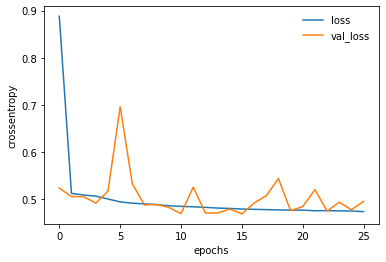

In [ ]:
# グラフ表示
loss = np.array([0.8880, 0.5127, 0.5092, 0.5068, 0.5007, 0.4946, 0.4918, 0.4904, 0.4887, 0.4863, 0.4851, 0.4842, 0.4830, 0.4815, 0.4807, 0.4794, 0.4788, 0.4782, 0.4776, 0.4771, 0.4772, 0.4758, 0.4760, 0.4756, 0.4753, 0.4739])
val_loss = np.array([0.5239, 0.5058, 0.5058, 0.4920, 0.5173, 0.6961, 0.5328, 0.4881, 0.4894, 0.4827, 0.4695, 0.5258, 0.4712, 0.4710, 0.4794, 0.4691, 0.4922, 0.5076, 0.5442, 0.4758, 0.4848, 0.5206, 0.4751, 0.4940, 0.4779, 0.4958])
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend(frameon=False) # 凡例の表示
plt.xlabel("epochs")
plt.ylabel("crossentropy")
plt.show()

≪結果≫  
lossの値も小さく、今までで最も良好なモデルになった。  
これでepoch数を増やして学習させてみる。

#### １１．Best CNN

In [ ]:
# 学習時間がかかるので途中でランタイムが切断されても、学習を再開できるよう細目にモデルを保存する
# モデル保存フォルダー
model_dir = "/content/drive/MyDrive/Colab Notebooks/Histopathologic Cancer Detection/modeltemp"
# ModelCheckpoint()の設定
checkpoint = ModelCheckpoint(filepath = os.path.join(model_dir, "model-{epoch:02d}.h5"),
                             monitor="loss",
                             verbose=1,
                             save_best_only=True,
                             save_weight_only=False,
                             mode="min",
                             period=1)

In [ ]:
# EarlyStopping()の設定(可動性upのためここではあらかじめ設定)
earlystopping =  EarlyStopping(monitor='val_loss',
                                min_delta=0,
                                patience=100,
                                verbose=1)

Epoch 1/1000
10107/10108 [============================>.] - ETA: 0s - loss: 1.0390 - accuracy: 0.7515
Epoch 1: loss improved from inf to 1.03903, saving model to /content/drive/MyDrive/Colab Notebooks/Histopathologic Cancer Detection/modeltemp/model-01.h5
10108/10108 [==============================] - 61s 5ms/step - loss: 1.0390 - accuracy: 0.7515 - val_loss: 0.5183 - val_accuracy: 0.7647
Epoch 2/1000
10105/10108 [============================>.] - ETA: 0s - loss: 0.5086 - accuracy: 0.7677
Epoch 2: loss improved from 1.03903 to 0.50863, saving model to /content/drive/MyDrive/Colab Notebooks/Histopathologic Cancer Detection/modeltemp/model-02.h5
10108/10108 [==============================] - 63s 6ms/step - loss: 0.5086 - accuracy: 0.7677 - val_loss: 0.5451 - val_accuracy: 0.7507
Epoch 3/1000
10100/10108 [============================>.] - ETA: 0s - loss: 0.5041 - accuracy: 0.7708
Epoch 3: loss improved from 0.50863 to 0.50410, saving model to /content/drive/MyDrive/Colab Notebooks/Histopa

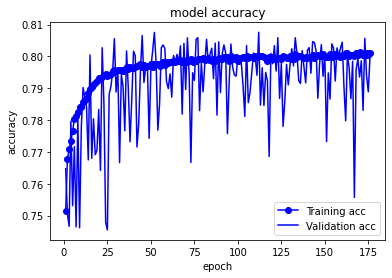

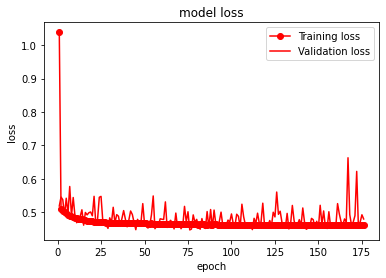

CPU times: user 2h 52min 20s, sys: 13min 38s, total: 3h 5min 58s
Wall time: 2h 36min 15s


In [ ]:
%%time
# 学習の実施
log = model.fit(X_train, Y_train, epochs=1000, batch_size=32, verbose=True,
                callbacks=[checkpoint, earlystopping], validation_data=(X_valid, Y_valid))

# グラフ描画
plt.clf()

# Accuracy
acc = log.history["accuracy"]
val_acc = log.history["val_accuracy"]
plot_epochs = range(1, len(acc)+1)
plt.plot(plot_epochs, acc, "bo-", label="Training acc")
plt.plot(plot_epochs, val_acc, "b", label="Validation acc")
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

# Loss
loss = log.history["loss"]
val_loss = log.history["val_loss"]
plot_epochs2 = range(1, len(loss)+1)
plt.plot(plot_epochs2, loss, "ro-", label="Training loss")
plt.plot(plot_epochs, val_loss, "r", label="Validation loss")
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [ ]:
# モデルの読み込み
model = load_model(os.path.join(model_dir, "model-174.h5")) 

## 【テストデータでの汎化性能確認】

In [ ]:
# 予測
Y_pred = model.predict(X_test)

6189/6189 [==============================] - 104s 17ms/step


In [ ]:
print(Y_pred.shape)
Y_pred

(198023, 1)


array([[0.78395617],
       [0.24076086],
       [0.8389896 ],
       ...,
       [0.3127729 ],
       [0.9923985 ],
       [0.48021287]], dtype=float32)

In [ ]:
# 予測結果の確率が0.5以下ならNegative(0)、それより大きければPositive(1)となる計算で分類結果を取得
Y_pred_cls = (Y_pred > 0.5).astype("int32")

In [ ]:
print(Y_pred_cls.shape)
Y_pred_cls

(198023, 1)


array([[1],
       [0],
       [1],
       ...,
       [0],
       [1],
       [0]], dtype=int32)

In [ ]:
print(Y_test.shape)
Y_test

(198023,)


array([1, 0, 1, ..., 1, 1, 0], dtype=uint8)

In [ ]:
# Y_pred_clsの形状をY_testに合わせる
Y_pred_ = Y_pred_cls.reshape(-1)

In [ ]:
print(Y_pred_.shape)
Y_pred_

(198023,)


array([1, 0, 1, ..., 0, 1, 0], dtype=int32)

In [ ]:
# モデルの評価
from sklearn.metrics import classification_report

print(classification_report(Y_test, Y_pred_))

              precision    recall  f1-score   support

           0       0.84      0.81      0.82    117868
           1       0.74      0.76      0.75     80155

    accuracy                           0.79    198023
   macro avg       0.79      0.79      0.79    198023
weighted avg       0.79      0.79      0.79    198023



## 【まとめ】  
- CNNを用いた画像分類のモデル構築を行い、画像のグレースケール化やデータの水増し（反転、回転）の効果を検討した。  
- 今回のモデルでは、グレースケール化画像よりも元のカラー画像のほうが精度が良いという結果になったが、元データの画像では色調のばらつきが大きく、その点をうまく補正する方法を今後検討してみたいと考えている。  
- 生物学的に考えると、リンパ節内における固形癌の転移の場合、細胞の形状（核と細胞質の比率、細胞の大きさ）が大きく異なると予想できるため、より細胞レベルで特徴量を学習するモデル（物体検知、エッジ検出などに手法が有効か？）が良いのではないかと考えられる。  